In [1]:
# Importing libraries
import numpy as np 
import pandas as pd 
import pickle
import matplotlib.pyplot as plt
import shap

In [2]:
# Importing test data
X_df = pd.read_csv("/workspace/anomaly_lte/data/x_test_processed_ft2.csv")

# Removing index created during feature engineering
X_df = X_df.iloc[:,1:]

# Randomly sampling 100 rows
RANDOM_SEED = 53
X_df_100rows = X_df.sample(n=100, random_state=RANDOM_SEED)

In [3]:
# Importing decision tree model
with open('models/train_xgboost_ft2.pkl', 'rb') as model_file:
    xgboost = pickle.load(model_file)

In [4]:
# Setting up SHAP explainer
explainer = shap.TreeExplainer(xgboost)
shap_values = explainer.shap_values(X_df_100rows)

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


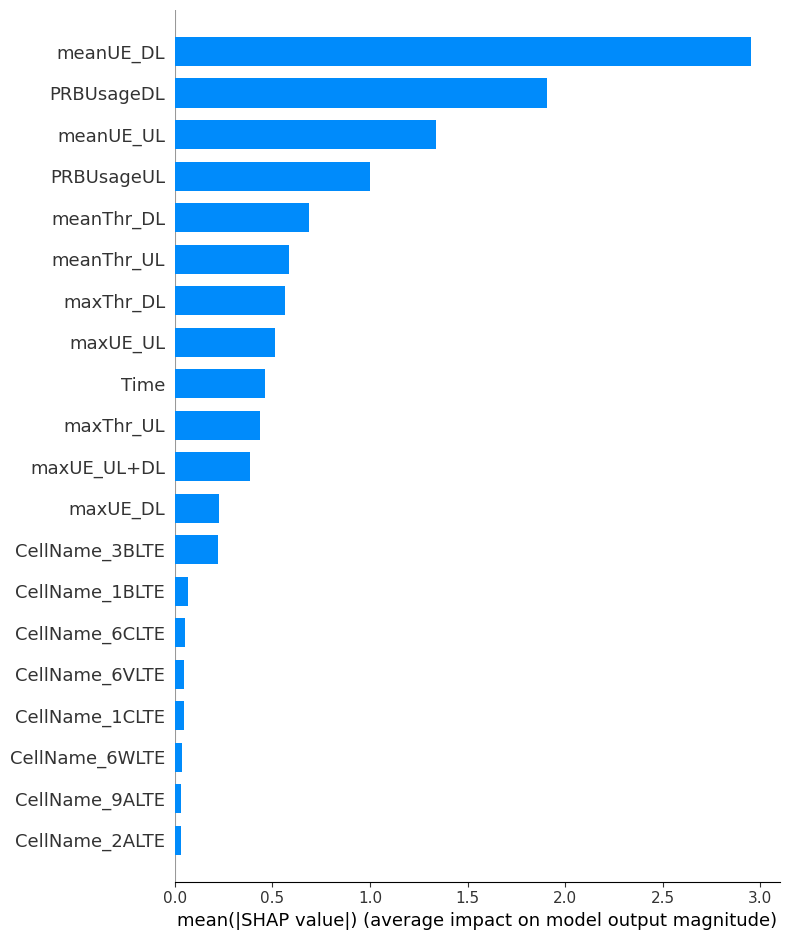

In [5]:
# Plotting Summary plot
shap.summary_plot(shap_values, X_df_100rows, plot_type='bar', class_names=['Normal', 'Anomalous'])
plt.show()